In [1]:
from transformers import pipeline
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import cv2

### Importando modelo

In [2]:
# Importando o modelo de segmentação de imagem
pipe = pipeline("image-segmentation", model="sayeed99/segformer_b3_clothes")

config.json:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

C:\Users\Nicole.Souza.HOMLABNOT002581\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nicole.Souza.HOMLABNOT002581\.cache\huggingface\hub\models--sayeed99--segformer_b3_clothes. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-developme

model.safetensors:   0%|          | 0.00/189M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

### Funções

In [3]:
# Função para plotar a imagem
def plot_PIL_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [4]:
def get_file_names_in_folder(folder_path):
  """Gets a list of file names within a specified folder.

  Args:
    folder_path: The path to the folder.

  Returns:
    A list of file names within the folder.
  """
  file_names = []
  for filename in os.listdir(folder_path):
    filename = os.path.join(folder_path, filename)
    file_names.append(filename)
  return file_names

In [5]:
# Função para calcular e aplicar o bounding box
def get_cropped_bound_rect(image, mask, percent=10):
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)

    # Encontrando contornos
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        raise ValueError("Nenhum contorno encontrado na máscara.")
    
    # Selecionando o maior contorno
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Calculando epsilon como porcentagem da largura da imagem
    epsilon = int(image.shape[1] * (percent / 100))
    
    # Ajustando com o epsilon
    x = max(0, x - epsilon)
    y = max(0, y - epsilon)
    w = min(image.shape[1] - x, w + 2 * epsilon)
    h = min(image.shape[0] - y, h + 2 * epsilon)
    
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image, (x, y, w, h)

# Função de visualização do bounding box
def visualize_bounding_box(image, x, y, w, h):
    img_copy = image.copy()
    cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Retângulo azul
    # plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    # plt.title("Bounding Box")
    # plt.show()
    return cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

### Testando a solução

In [16]:
folder_path = 'teste_images_mod_2'
file_names = get_file_names_in_folder(folder_path)
print(file_names[:10])

['teste_images_mod_2\\SHORT.jpg', 'teste_images_mod_2\\V.png', 'teste_images_mod_2\\VEST_BRANCO.png', 'teste_images_mod_2\\VEST_CURTO.png', 'teste_images_mod_2\\VEST_VERMELHO.png']


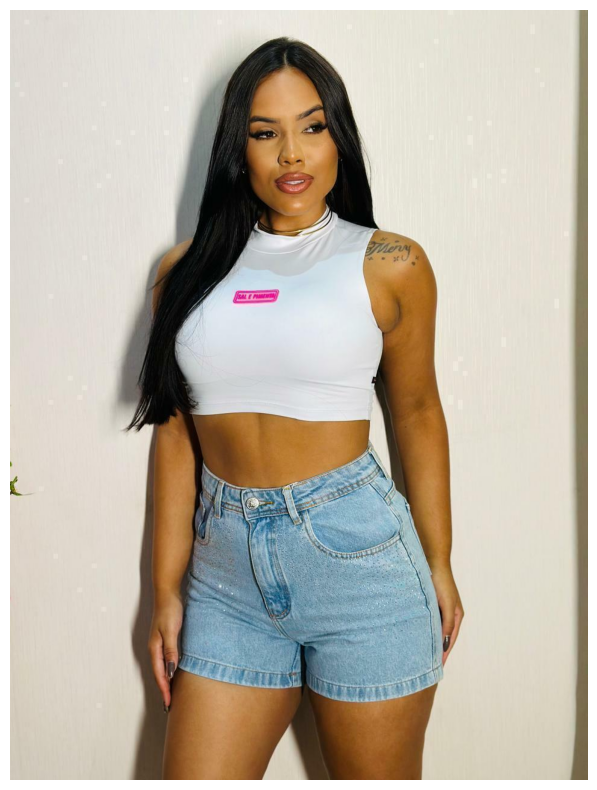

[{'score': None,
  'label': 'Background',
  'mask': <PIL.Image.Image image mode=L size=960x1280>},
 {'score': None,
  'label': 'Hair',
  'mask': <PIL.Image.Image image mode=L size=960x1280>},
 {'score': None,
  'label': 'Upper-clothes',
  'mask': <PIL.Image.Image image mode=L size=960x1280>},
 {'score': None,
  'label': 'Pants',
  'mask': <PIL.Image.Image image mode=L size=960x1280>},
 {'score': None,
  'label': 'Face',
  'mask': <PIL.Image.Image image mode=L size=960x1280>},
 {'score': None,
  'label': 'Left-leg',
  'mask': <PIL.Image.Image image mode=L size=960x1280>},
 {'score': None,
  'label': 'Right-leg',
  'mask': <PIL.Image.Image image mode=L size=960x1280>},
 {'score': None,
  'label': 'Left-arm',
  'mask': <PIL.Image.Image image mode=L size=960x1280>},
 {'score': None,
  'label': 'Right-arm',
  'mask': <PIL.Image.Image image mode=L size=960x1280>}]

In [19]:
# Carrregando imagem para teste
original_img = Image.open(file_names[0])
plot_PIL_image(original_img)

# Aplicando o modelo de segmentação
results = pipe(file_names[0])
results

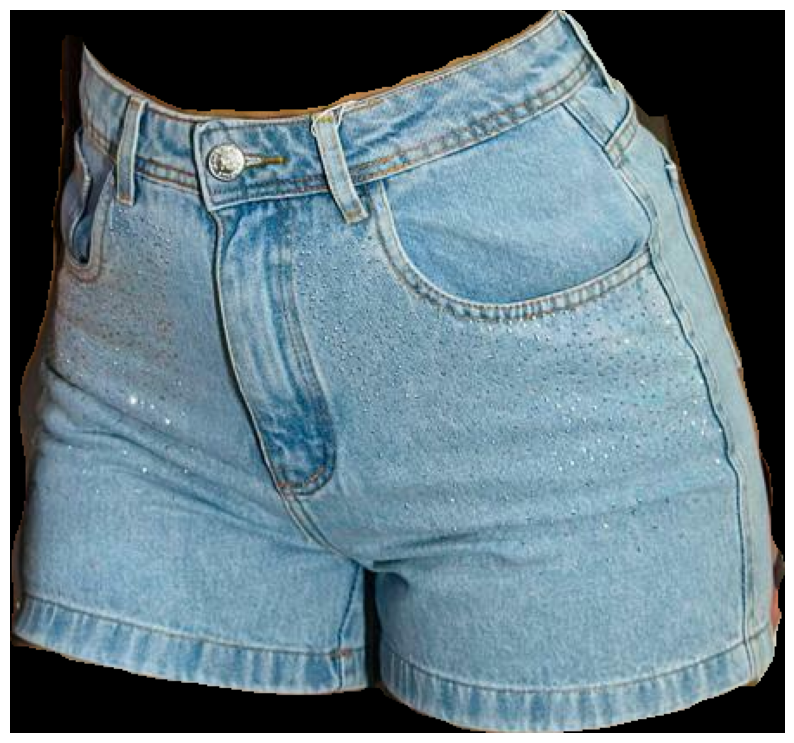

In [20]:
# Obtendo a máscara da roupa superior
upper_clothes_mask = [r["mask"] for r in results if r["label"] == "Pants"][0]
upper_clothes = ImageChops.multiply(original_img, upper_clothes_mask.convert("RGB"))

# Encontrando o bounding rect da imagem e pegando apenas essa parte
bbox = upper_clothes_mask.getbbox()
upper_clothes = upper_clothes.crop(bbox)
plot_PIL_image(upper_clothes)

In [9]:
len(file_names)

892

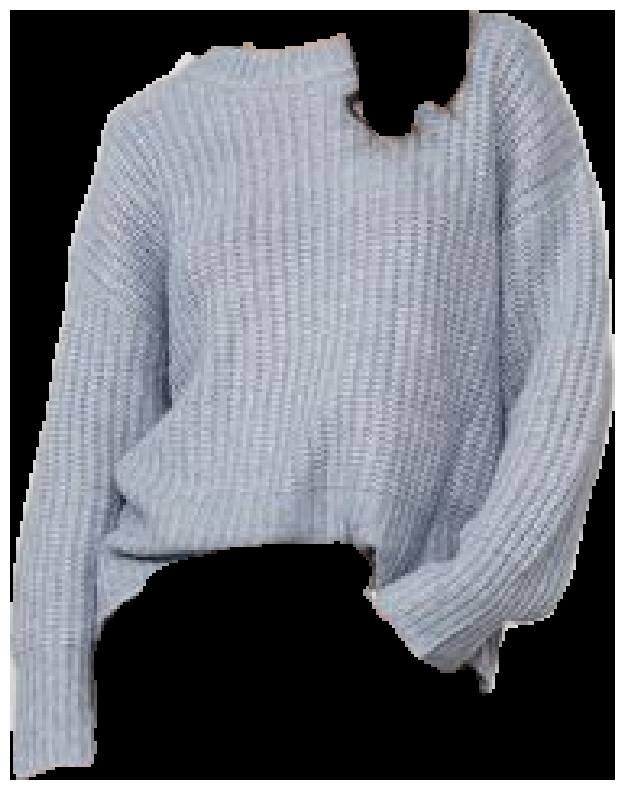

In [10]:
original_img = Image.open(file_names[77])
results = pipe(file_names[77])

# Obtendo a máscara da roupa superior
upper_clothes_mask = [r["mask"] for r in results if r["label"] == "Upper-clothes"][0]
upper_clothes = ImageChops.multiply(original_img, upper_clothes_mask.convert("RGB"))

# Encontrando o bounding rect da imagem e pegando apenas essa parte
bbox = upper_clothes_mask.getbbox()
upper_clothes = upper_clothes.crop(bbox)

plot_PIL_image(upper_clothes)

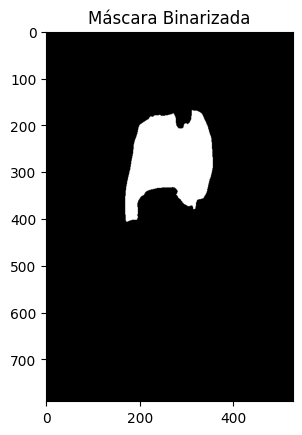

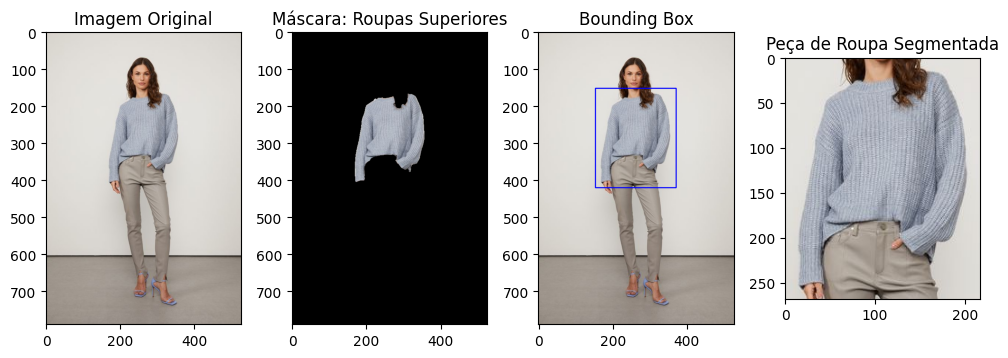

In [23]:
# Certificando-se de que as dimensões da máscara e da imagem são consistentes
if upper_clothes_mask.size != original_img.size:
    upper_clothes_mask = upper_clothes_mask.resize(original_img.size)

# Convertendo a máscara para NumPy
upper_clothes_mask_np = np.array(upper_clothes_mask)
upper_clothes_mask_np = (upper_clothes_mask_np > 0).astype(np.uint8)  # Garante que seja binária

# # Visualizando imagem original
# plt.imshow(original_img)
# plt.title("Imagem Original")
# plt.show()

# Visualizando a máscara binarizada
plt.imshow(upper_clothes_mask_np, cmap="gray")
plt.title("Máscara Binarizada")
plt.show()


# Convertendo a imagem para NumPy
original_img_np = np.array(original_img)
original_img_np = cv2.cvtColor(original_img_np, cv2.COLOR_BGR2RGB)

# Expandindo a máscara para 3 canais (RGB)
upper_clothes_mask_np_rgb = cv2.merge([upper_clothes_mask_np] * 3)

# Aplicando a máscara à imagem original
masked_image = upper_clothes_mask_np_rgb * original_img_np

# Calculando o bounding box com ajuste baseado em porcentagem
cropped_image, bounding_box = get_cropped_bound_rect(original_img_np, upper_clothes_mask_np, percent=3)
x, y, w, h = bounding_box
# visualize_bounding_box(original_img_np, x, y, w, h)

# # Exibindo o resultado
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(original_img)
# plt.title("Imagem Original")

# plt.subplot(1, 2, 2)
# visualize_bounding_box(original_img_np, x, y, w, h)

# # Exibindo o resultado
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
# plt.title("Roupas Superiores (Máscara)")

# plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
# plt.title("Roupas Superiores Segmentadas")
# plt.show()


# Configurando a figura para exibir 4 imagens lado a lado
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# Imagem 1: Original
axs[0].imshow(original_img)
axs[0].set_title("Imagem Original")

# Imagem 2: Máscara de Roupas Superiores
axs[1].imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
axs[1].set_title("Máscara: Roupas Superiores")

# Imagem 3: Imagem com Bounding Box
axs[2].imshow(visualize_bounding_box(original_img_np, x, y, w, h))
axs[2].set_title("Bounding Box")

# Imagem 4: Segmentação Final
axs[3].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
axs[3].set_title("Peça de Roupa Segmentada")

# Ajustar o espaçamento
plt.tight_layout()
plt.show()


## Implementando a solução

### Segregando imagens por grupo de produto

In [201]:
folder_path = 'animale_images'
file_names = get_file_names_in_folder(folder_path)

In [202]:
# Criando df com file_names 
df_file_names = pd.DataFrame(file_names, columns=['file_names'])

In [203]:
# Criando coluna auxiliar excluindo a string 'animale_images\' do nome do arquivo
df_file_names['file_names_aux'] = df_file_names['file_names'].str.replace(r'animale_images\\', '', regex=True)

In [204]:
df_file_names

,file_names,file_names_aux
0,animale_images\blazer_blazer-alfaiataria-est-o...,blazer_blazer-alfaiataria-est-onca-jacquard_be...
1,animale_images\blazer_blazer-alongado-marrom-n...,blazer_blazer-alongado-marrom-nozes-sem-lapela...
2,animale_images\blazer_blazer-cinque-off-white_...,blazer_blazer-cinque-off-white_off-white_03-04...
3,animale_images\blazer_blazer-cinque-preto_pret...,blazer_blazer-cinque-preto_preto_03-04-0461-00...
4,animale_images\blazer_blazer-com-transpasse-de...,blazer_blazer-com-transpasse-de-crepe-off-whit...
...,...,...
887,animale_images\vestido_vestido-tricot-transpar...,vestido_vestido-tricot-transparencia_preto_07-...
888,animale_images\vestido_vestido-tube_laranja-au...,vestido_vestido-tube_laranja-aura_07-20-6402-0...
889,animale_images\vestido_vestido-tube_preto_07-2...,vestido_vestido-tube_preto_07-20-6401-0005.jpg
890,animale_images\vestido_vestido-tule-babados-li...,vestido_vestido-tule-babados-lili-est-leopardo...


In [205]:
# Criando colunas com cada parte de um split '_'
df_file_names[['grupo_produto', 'desc_produto', 'cor', 'id_produto']] = df_file_names['file_names_aux'].str.split('_', expand=True)

# Exclui coluna auxiliar
df_file_names = df_file_names.drop(columns=['file_names_aux'])

In [206]:
# Substituindo os grupos 'camisa' e 'top-blusa' por 'blusa'
df_file_names['grupo_produto'] = df_file_names['grupo_produto'].replace({'camisa': 'blusa', 'top-blusa': 'blusa'})

In [207]:
df_file_names

,file_names,grupo_produto,desc_produto,cor,id_produto
0,animale_images\blazer_blazer-alfaiataria-est-o...,blazer,blazer-alfaiataria-est-onca-jacquard,bege,03-04-0464-0030.jpg
1,animale_images\blazer_blazer-alongado-marrom-n...,blazer,blazer-alongado-marrom-nozes-sem-lapela,marrom-nozes,03-04-0478-6048.jpg
2,animale_images\blazer_blazer-cinque-off-white_...,blazer,blazer-cinque-off-white,off-white,03-04-0460-0003.jpg
3,animale_images\blazer_blazer-cinque-preto_pret...,blazer,blazer-cinque-preto,preto,03-04-0461-0005.jpg
4,animale_images\blazer_blazer-com-transpasse-de...,blazer,blazer-com-transpasse-de-crepe-off-white,off-white,03-04-0479-0024.jpg
...,...,...,...,...,...
887,animale_images\vestido_vestido-tricot-transpar...,vestido,vestido-tricot-transparencia,preto,07-20-6778-0005.jpg
888,animale_images\vestido_vestido-tube_laranja-au...,vestido,vestido-tube,laranja-aura,07-20-6402-09248.jpg
889,animale_images\vestido_vestido-tube_preto_07-2...,vestido,vestido-tube,preto,07-20-6401-0005.jpg
890,animale_images\vestido_vestido-tule-babados-li...,vestido,vestido-tule-babados-lili-est-leopardo,est-leopardo,07-20-6659-09538.jpg


In [208]:
df_file_names['grupo_produto'].value_counts()

blusa      353
vestido    219
calca      177
saia        81
short       43
blazer      19
Name: grupo_produto, dtype: int64

In [209]:
# Criando dicionário pra setar qual máscara será utilizada para cada grupo de produto
masks_dict = {
    'blusa': 'Upper-clothes',
    'blazer': 'Upper-clothes',
    'calca': 'Pants',
    'saia': 'Skirt',
    'short': 'Pants',
    'vestido': 'Dress',
}

### Função para recortar as imagens e salvar em disco

In [199]:
def crop_and_save_images(file_names, grupo_produto, save_path):
    # Verificando se o grupo de produto está no dicionário de máscaras
    if grupo_produto not in masks_dict:
        raise ValueError(f"Grupo de produto '{grupo_produto}' não encontrado no dicionário de máscaras.")
    
    # Obtém a máscara correspondente ao grupo de produto
    mask_label = masks_dict[grupo_produto]
    
    for file_name in file_names:
        try:
            # Carrega a imagem original
            original_img = Image.open(file_name)
            
            # Aplica o modelo de segmentação
            results = pipe(file_name)
            
            # Obtém a máscara correspondente ao grupo de produto
            mask = [r["mask"] for r in results if r["label"] == mask_label][0]
            
            # Certifica-se de que as dimensões da máscara e da imagem são consistentes
            if mask.size != original_img.size:
                mask = mask.resize(original_img.size)
            
            # Converte a máscara para NumPy
            mask_np = np.array(mask)
            mask_np = (mask_np > 0).astype(np.uint8)  # Garante que seja binária
            
            # Converte a imagem para NumPy
            original_img_np = np.array(original_img)
            original_img_np = cv2.cvtColor(original_img_np, cv2.COLOR_BGR2RGB)
            
            # Calcula o bounding box com ajuste baseado em porcentagem
            cropped_image, bounding_box = get_cropped_bound_rect(original_img_np, mask_np, percent=3)
            
            # Converte a imagem recortada de volta para PIL
            cropped_image_pil = Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
            
            # Salva a imagem recortada no caminho especificado
            save_file_name = os.path.join(save_path, os.path.basename(file_name))
            cropped_image_pil.save(save_file_name)
        except Exception as e:
            print(f"Erro ao processar '{file_name}': {e}")

In [210]:
df_file_names

,file_names,grupo_produto,desc_produto,cor,id_produto
0,animale_images\blazer_blazer-alfaiataria-est-o...,blazer,blazer-alfaiataria-est-onca-jacquard,bege,03-04-0464-0030.jpg
1,animale_images\blazer_blazer-alongado-marrom-n...,blazer,blazer-alongado-marrom-nozes-sem-lapela,marrom-nozes,03-04-0478-6048.jpg
2,animale_images\blazer_blazer-cinque-off-white_...,blazer,blazer-cinque-off-white,off-white,03-04-0460-0003.jpg
3,animale_images\blazer_blazer-cinque-preto_pret...,blazer,blazer-cinque-preto,preto,03-04-0461-0005.jpg
4,animale_images\blazer_blazer-com-transpasse-de...,blazer,blazer-com-transpasse-de-crepe-off-white,off-white,03-04-0479-0024.jpg
...,...,...,...,...,...
887,animale_images\vestido_vestido-tricot-transpar...,vestido,vestido-tricot-transparencia,preto,07-20-6778-0005.jpg
888,animale_images\vestido_vestido-tube_laranja-au...,vestido,vestido-tube,laranja-aura,07-20-6402-09248.jpg
889,animale_images\vestido_vestido-tube_preto_07-2...,vestido,vestido-tube,preto,07-20-6401-0005.jpg
890,animale_images\vestido_vestido-tule-babados-li...,vestido,vestido-tule-babados-lili-est-leopardo,est-leopardo,07-20-6659-09538.jpg


In [151]:
for grupo_produto in df_file_names['grupo_produto'].unique():
    df_grupo_produto = df_file_names[df_file_names['grupo_produto'] == grupo_produto]

    save_path = f"animale_images_cropped/{grupo_produto}"
    os.makedirs(save_path, exist_ok=True)
    print(f"Diretório criado: {save_path}")

    file_names = df_grupo_produto['file_names'].to_list()

    # Chamando a função para recortar e salvar as imagens
    crop_and_save_images(file_names, grupo_produto, save_path)


Diretório criado: animale_images_cropped/blazer
Erro ao processar 'animale_images\blazer_blazer-sem-lapela-brocado-mini-flower_marrom-nozes_03-04-0472-6048.jpg': list index out of range
Diretório criado: animale_images_cropped/calca
Erro ao processar 'animale_images\calca_calca-cenoura-cos-pala-drapeado-estampada_est-liberty-camomila-preto-p_25-34-1677-09550.jpg': list index out of range
Erro ao processar 'animale_images\calca_calca-de-georgette-pesado-pareo-azul-cintura-alta_azul-grotto_25-34-1907-04084.jpg': list index out of range
Erro ao processar 'animale_images\calca_calca-de-georgette-pesado-pareo-cintura-alta-estampada_est-cobra-biscione-natureza_25-34-1745-09539.jpg': list index out of range
Erro ao processar 'animale_images\calca_calca-reta-laranja-sun-com-recorte_laranja-sun_25-34-1800-6032.jpg': list index out of range
Diretório criado: animale_images_cropped/blusa
Erro ao processar 'animale_images\camisa_camisa-de-couro-sem-manga-cinto-rolote_preto_52-05-1465-0005.jpg': li

Os erros de processamento acontecem quando o modelo não consegue capturar a máscara correta correspondente ao grupo do produto. Isso ocorre quando na imagem não é perceptível a diferença entre as peças de roupa. Por exemplo, quando a blusa e a calça são da mesma cor e a transição não é perceptível, o modelo captura a máscara de vestido ao invés das peças separadas.

Vamos utilizar isso como uma filtragem das imagens, não é de nosso interesse recortar imagens que não possuem máscaras corretas.

### Limpeza nas imagens recortadas

In [167]:
# Obter os arquivos originais e retirando '\animale_images\' do nome do arquivo
original_files = get_file_names_in_folder('animale_images')
original_files = [file.replace('animale_images\\', '') for file in original_files]

# Criar lista para armazenar arquivos correspondentes
cropped_files = []

# Iterar sobre os grupos de produtos e verificar correspondência
for grupo_produto in df_file_names['grupo_produto'].unique():
    cropped_group_files = get_file_names_in_folder(f'animale_images_cropped/{grupo_produto}')
    cropped_group_files = [file.replace(f'animale_images_cropped/{grupo_produto}\\', '') for file in cropped_group_files]

    # Adicionar apenas os arquivos que estão em `original_files`
    cropped_files.extend([file for file in cropped_group_files if file in original_files])

# Identificar os arquivos que estão em `animale_images` mas não em `cropped_files`
diff_files = list(set(original_files) - set(cropped_files))

# Exibir a quantidade de arquivos que faltam
len(diff_files)


102

top-blusa_blusa-de-viscose-maquinetada-alca-de-corda-detalhe-decote-torcido-preta_preto_52-13-5403-0005.jpg


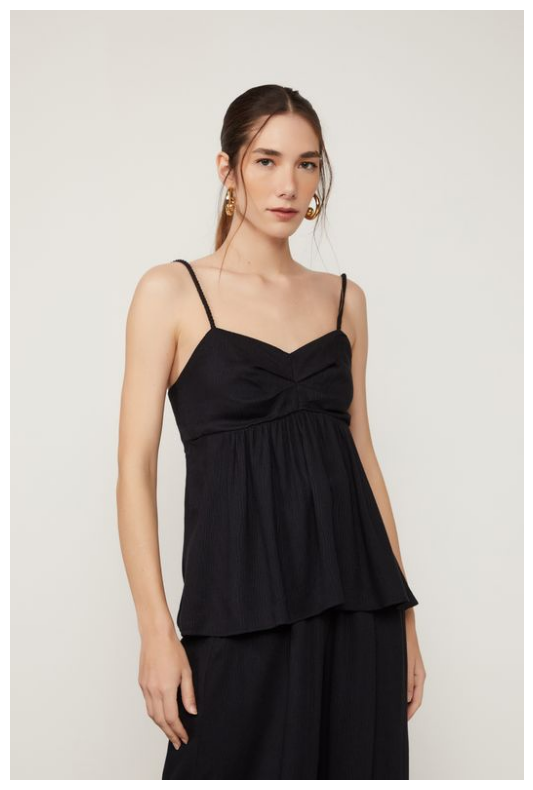

vestido_vestido-mini-manga-longa-com-gola-v-est_est-lenco-pois-recote-m_07-20-6381-09608.jpg


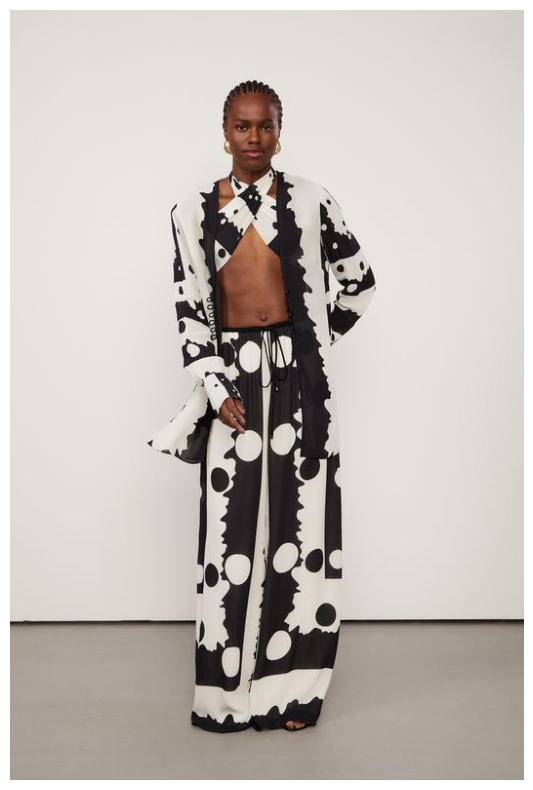

top-blusa_blusa-de-algodao-contraforma-bege_bege-gergelim_52-13-5313-09247.jpg


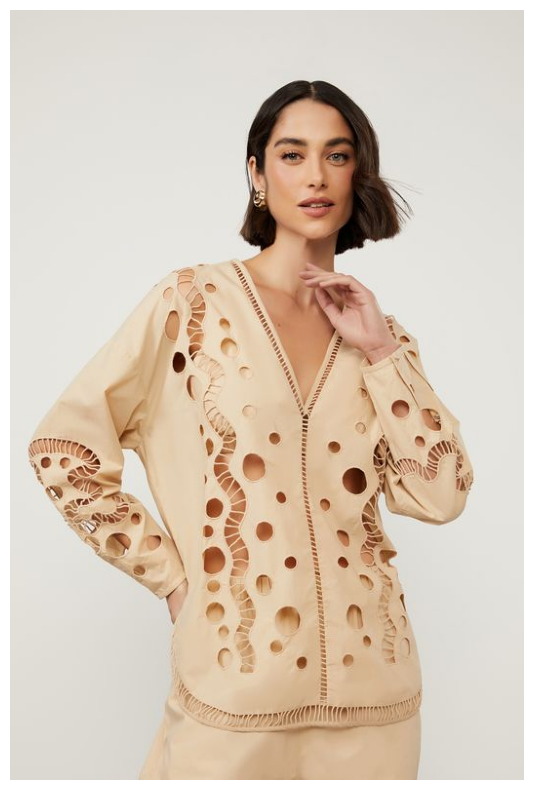

saia_saia-de-seda-midi-preta-barra-de-renda_preto_25-11-1052-0005.jpg


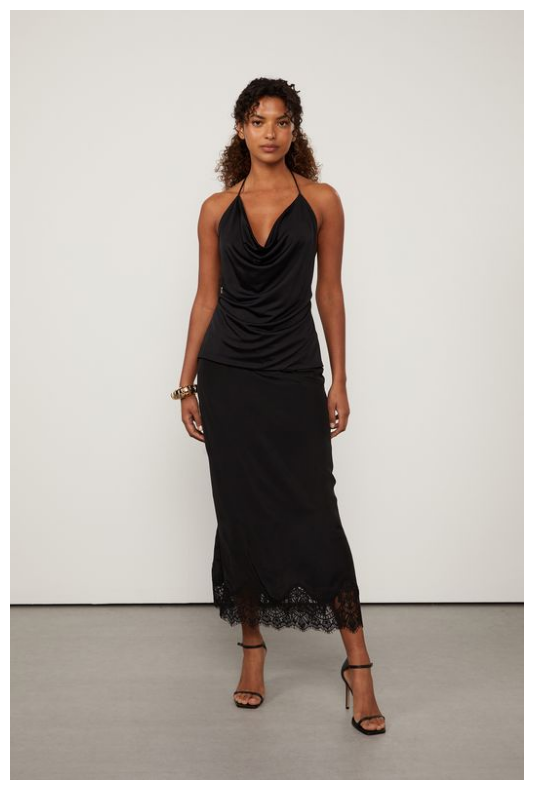

short_short-saia-de-algodao-texturizado_bege-flan_25-13-0096-09276.jpg


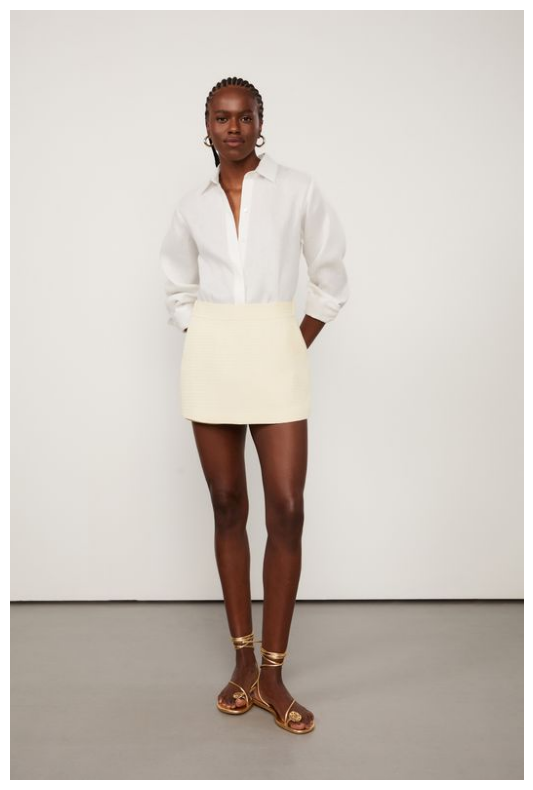

In [170]:
# Plotando alguns exemplos de diff_files
for file in diff_files[:5]:
    original_img = Image.open(f'animale_images/{file}')
    print(file)
    plot_PIL_image(original_img)


Algumas imagens foram recortadas incorretamente, então faremos uma limpeza manual e salvar os file_names em uma lista para serem separados em outra pasta.

In [175]:
# Lista de arquivos que serão movidos
incorret_files = [
    'camisa_camisa-de-georgette-ampla-estampado_est-onca-leve-flan_52-05-1612-09845',
    'top-blusa_blusa-com-decote-reto-e-alca-de-renda-az_azul-blue_52-13-5315-09244',
    'top-blusa_blusa-drapeada-com-laco-marinho-sodalita_marinho-sodalita_52-13-5311-6215',
    'top-blusa_rasteira-de-couro-listras_vermelho-fiery_09-01-2582-8259',
    'top-blusa_regata-de-crepe-verde-folha_verde-folha_52-10-5173-09258',
    'top-blusa_regata-de-malha-off-white-com-recorte-no_off-white_07-20-6457-0024',
    'top-blusa_top-de-alca-verde-exotique_verde-exotique_52-10-5285-5339',
    'top-blusa_top-de-georgette-pesado-amaracao-estampado-decote-v_est-loc-abstrato-solsticio-p_52-10-5280-09812',
    'top-blusa_top-jeans-frente-unica_jeans-medio_52-10-5287-0105',
    'top-blusa_top-triangulo-de-malha-lurex-floral-intimates_est-floral-vagalume-lima_52-08-0791-09831',
    'top-blusa_tunica-sem-manga-com-abotoamento_bege_07-20-6400-0030',
    'calca_calca-de-couro-com-cinto-barra-botoes_laranja-aura_25-34-1735-09248',
    'calca_calca-de-georgette-leve-flare-estampada-cintura-alta_est-abstrato-silhuetas-yucca_25-34-1954-09792',
    'calca_calca-de-georgette-leve-reta-estampada_est-listra-spirulina-color_25-34-1737-09556',
    'calca_calca-de-georgette-pesado-pareo-estampada-reta_est-loc-abstrato-solsticio-p_25-34-1953-09812',
    'calca_calca-de-malha-pantalona-satin-nude_nude-cogumelo_25-34-1716-09250',
    'calca_calca-pantalona-de-viscose-maquinetada-cos-de-elastico-detalhe-amarracao-de-corda-vermelha_vermelho-argila_25-34-1710-09050',
    'calca_calca-reta-verde-cha-com-recorte-frontal_verde-cha_25-34-1653-04356',
    'calca_legging-elastic_preto_25-34-1693-0005',
    'saia_saia-de-georgette-midi-preta-babados_preto_25-11-1222-0005',
    'saia_saia-de-seda-midi-rosa-cos-de-elastico_rosa-strawberry_25-11-1262-04528',
    'saia_saia-midi-detalhe-cos-de-lastex-com-cinto-off-white_off-white_25-11-1241-0003',
    'short_short-de-couro-cos-aplicado-fraldado_bege-whitecap_25-05-4044-04346',
    'vestido_vestido-de-malha-brilho-midi-preto-ombro-so-e-cut-lateral_preto_07-20-6624-0005'
]

# Acrescentando a extensão '.jpg' aos arquivos
incorret_files = [f'{file}.jpg' for file in incorret_files]

# Criando pasta para arquivos incorretos
os.makedirs('animale_images_cropped/incorretos', exist_ok=True)

# Movendo arquivos para a pasta correta
for file in incorret_files:
    grupo_produto = file.split('_')[0]

    # Se o grupo for camisa ou top-blusa, substituir por blusa
    if grupo_produto in ['camisa', 'top-blusa']:
        grupo_produto = 'blusa'

    original_file_path = f'animale_images_cropped/{grupo_produto}/{file}'
    new_file_path = f'animale_images_cropped/incorretos/{file}'

    print(f'Movendo {original_file_path} para {new_file_path}')
    os.rename(original_file_path, new_file_path)


Movendo animale_images_cropped/blusa/camisa_camisa-de-georgette-ampla-estampado_est-onca-leve-flan_52-05-1612-09845.jpg para animale_images_cropped/incorretos/camisa_camisa-de-georgette-ampla-estampado_est-onca-leve-flan_52-05-1612-09845.jpg
Movendo animale_images_cropped/blusa/top-blusa_blusa-com-decote-reto-e-alca-de-renda-az_azul-blue_52-13-5315-09244.jpg para animale_images_cropped/incorretos/top-blusa_blusa-com-decote-reto-e-alca-de-renda-az_azul-blue_52-13-5315-09244.jpg
Movendo animale_images_cropped/blusa/top-blusa_blusa-drapeada-com-laco-marinho-sodalita_marinho-sodalita_52-13-5311-6215.jpg para animale_images_cropped/incorretos/top-blusa_blusa-drapeada-com-laco-marinho-sodalita_marinho-sodalita_52-13-5311-6215.jpg
Movendo animale_images_cropped/blusa/top-blusa_rasteira-de-couro-listras_vermelho-fiery_09-01-2582-8259.jpg para animale_images_cropped/incorretos/top-blusa_rasteira-de-couro-listras_vermelho-fiery_09-01-2582-8259.jpg
Movendo animale_images_cropped/blusa/top-blusa_r

In [176]:
len(incorret_files)

24

Produtos que caíram:
- 102 produtos que não foram processados
- 24 produtos processados incorretamente

Totalizando 126 produtos que caíram da base no processo de recorte.

In [236]:
cropped_group_files = []

for grupo_produto in df_file_names['grupo_produto'].unique():
    # Adicionar arquivos diretamente
    cropped_group_files.extend(get_file_names_in_folder(f'animale_images_cropped/{grupo_produto}/'))

print(f'Total de imagens: {len(cropped_group_files)}')

Total de imagens: 766


In [237]:
# Criando df com cropped_group_files
df_cropped_files = pd.DataFrame(cropped_group_files, columns=['file_path'])

# Criando coluna com a ultima parte do split por '_' com o id do produto
df_cropped_files['id_produto'] = df_cropped_files['file_path'].str.split('_').str[-1].str.replace('.jpg', '')

df_cropped_files

C:\Users\Cole\AppData\Local\Temp\ipykernel_22156\1584779294.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cropped_files['id_produto'] = df_cropped_files['file_path'].str.split('_').str[-1].str.replace('.jpg', '')


,file_path,id_produto
0,animale_images_cropped/blazer/blazer_blazer-alfaiataria-est-onca-jacquard_bege_03-04-0464-0030.jpg,03-04-0464-0030
1,animale_images_cropped/blazer/blazer_blazer-alongado-marrom-nozes-sem-lapela_marrom-nozes_03-04-0478-6048.jpg,03-04-0478-6048
2,animale_images_cropped/blazer/blazer_blazer-cinque-off-white_off-white_03-04-0460-0003.jpg,03-04-0460-0003
3,animale_images_cropped/blazer/blazer_blazer-cinque-preto_preto_03-04-0461-0005.jpg,03-04-0461-0005
4,animale_images_cropped/blazer/blazer_blazer-com-transpasse-de-crepe-off-white_off-white_03-04-0479-0024.jpg,03-04-0479-0024
5,animale_images_cropped/blazer/blazer_blazer-cropped-uno-amarelo-narciso_amarelo-narciso_03-04-0462-09256.jpg,03-04-0462-09256
6,animale_images_cropped/blazer/blazer_blazer-de-algodao-khaki_caqui_03-04-0447-0278.jpg,03-04-0447-0278
7,animale_images_cropped/blazer/blazer_blazer-de-couro-acinturado-botoes-organicos_bege-whitecap_03-01-1628-04346.jpg,03-01-1628-04346
8,animale_images_cropped/blazer/blazer_blazer-de-crepe-bege-cropped_bege-manha_03-04-0431-09041.jpg,03-04-0431-09041
9,animale_images_cropped/blazer/blazer_blazer-de-crepe-off-white_off-white_03-04-0491-0003.jpg,03-04-0491-0003


In [238]:
# Criando coluna com grupo de produto e outra com file_name
df_cropped_files['grupo_produto'] = df_cropped_files['file_path'].str.split('/').str[1]

df_cropped_files['file_name'] = df_cropped_files['file_path'].str.split('/').str[2]


In [239]:
pd.set_option('display.max_colwidth', None)

In [240]:
df_cropped_files['file_name'].sample(2)

193    camisa_camisa-de-georgette-com-manga-curta-estampado_est-pois-tri-preto-e-exotique_52-05-1536-09563.jpg
559                               vestido_vestido-curto-assimetrico-bege-kirli_bege-kirli_07-20-6417-03023.jpg
Name: file_name, dtype: object

In [241]:
df_cropped_files['grupo_produto'].value_counts()

blusa      299
vestido    216
calca      165
saia        41
short       27
blazer      18
Name: grupo_produto, dtype: int64

In [242]:
# Salvando df_cropped_files
df_cropped_files.to_parquet('datasets/base_animale_filtrada.parquet')